# Спектральная Кластеризация

### Алим Бухараев

В данном блокноте реализуются и сравниваются два метода спектральной кластеризации: "классический" (unnormalized spectral clustering) и описнный в статье Andrew Ng et al. On Spectral Clustering: Analysis and an algorithm (normalized s. c.)

https://papers.nips.cc/paper/2092-on-spectral-clustering-analysis-and-an-algorithm.pdf

Рекомендуемая литература для лучшего понимания статьи:

www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488[0].pdf

Для данного графа (Yahoo music), где каждая из двух тысяч вершин - исполнитель,
а веса рёбер соответствуют количеству совместных прослушиваний, были применены 
два алгоритма спектральной кластеризации,
основанные на минимизации RatioCut и Ncut соответсвенно.

Хочется выразить благодарность Beatrice Ionascu и Diego Yus Lopez, их работа сильно
облегчила создание данного блокнота

https://github.com/bionascu/graph-spectra

Исходный граф:
    
https://drive.google.com/file/d/0Bwd5a7NScgMtNElfOFdSbE1UYnM/view
    
Используемый мной для задания весов графа файл:
    
https://drive.google.com/open?id=1b10yDT8_BuAULpSArQbpGYEXPmfoybd-    

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy

### Загрузим граф

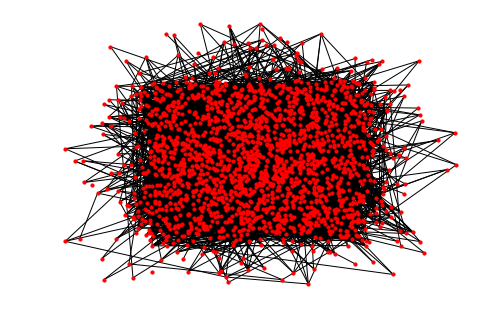

In [2]:
G = nx.read_gml("/home/alimbfromlimb/Downloads/music_sna/music2K.gml") # замените на ваш путь
nx.draw(G, node_size=10, pos=nx.spring_layout(G, k=0.03, iterations=2))
plt.show()

# граф на картинке построен без учёта весов ребёр!

### Прочитаем список исполнителей и догрузим данные о весах графа

In [3]:
# веса в данном графе были очень малы - для Ncut это будет критично. 
# попробую домножить все веса на 1000000
# так мы избежим проблемы накоплений неточности, связанной с представлением целых чисел
# но возможно это слишком много и стоит выбрать другое число

# с помощью networkx у меня не получилось извлечь из графа веса
# поэтому пришлось это делать вручную
# weights.txt - исходный файл, отредактированный таким образом, чтоб было удобно извлечь w
f = open("/home/alimbfromlimb/Downloads/music_sna/weights.txt", "r+")
x = f.read()
x = x.splitlines()
weights = x[0::5]
weights_int = []
weights[0] = '000000000000000000000'
for w in weights:
    a = w[11:]
    b = float(a)
    weights_int.append(b)
f.close()
weights_final = weights_int[1:]
# weights_final - список весов

# аналогично, создадим список артистов
f = open("/home/alimbfromlimb/Downloads/music_sna/artists.txt", "r+")
artists = f.read()
artists = artists.splitlines()
f.close

# добавим веса в сам граф (на самом деле, это нам не пригодится)
# на практике удобнее использовать веса из weights_final, данный шаг можно пропустить
i = 0
for e in G.edges():
    #G[source][target]['weight'] = weight
    G[e[0]][e[1]]['weight'] = int(weights_final[i] * 1000000) # weights_final[i]
    i += 1
    
# создаём списки вершин и рёбер
nodes = G.nodes
num_nodes = len(list(nodes))
edges = []
for e in G.edges:
    k = [int(e[0]), int(e[1])]
    edges.append(tuple(k))    

In [4]:
# Построим матрицу смежности A
A = np.zeros([num_nodes, num_nodes])
for i in range(len(edges)):
    A[edges[i][0], edges[i][1]] = int(weights_final[i] * 1000000) 
    A[edges[i][1], edges[i][0]] = int(weights_final[i] * 1000000) 
    
# Строим матрицу степеней D    
D = np.diag(np.sum(A, axis=1))
    
# Удалим одинокие вершины    
k = 0
for i in range(num_nodes):
    if (D[k][k]) == 0:
        D = np.delete(D, k, 0)
        D = np.delete(D, k, 1)
        A = np.delete(A, k, 0)
        A = np.delete(A, k, 1)
        del artists[k]
        G.remove_node(str(i))
    else:
        k += 1

# Посчитаем D в -1/2        
D_ = np.linalg.inv(np.sqrt(D))

# Построим Лапласиан
L = D - A

# Вычислим L_sym
L_sym = np.dot(np.dot(D_, A), D_)

## Для начала попробуем классический метод (min RatioCut)

Попробуем разделить граф на две части и посмотрим, что из этого выйдет.

24  artists

Masque 
Dawkins & Dawkins
Karen Clark Sheard 
Dr. Charles G. Hayes & The Cosmopolitan Warriors 
Gary Oliver
BeBe & CeCe Winans 
Woody Rock 
Donald Lawrence
Richard Smallwood
Mary Mary
Deitrick Haddon
Carlton Pearson
Anointed Pace Sisters
Norman Hutchins
Virtue 
John P. Kee
Rev. James Cleveland 
LaShun Pace
Gods Property 
BeBe Winans
Michael Fletcher 
Winans Phase 2 
The Clark Sisters
Michael Speaks 


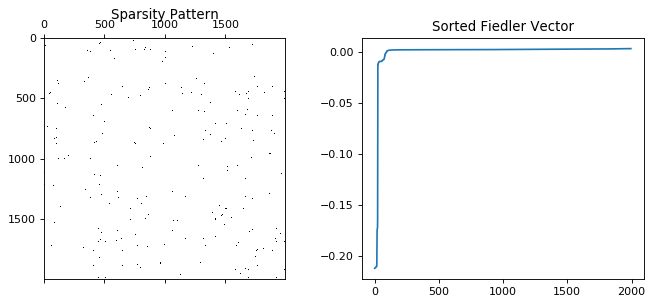

In [5]:
# Собственные значения и собственные вектора в возрастающей последовательности
w, X = scipy.linalg.eigh(L) 

# Достанем Fiedler Vector: собственный вектор, соответствующий
# второму минимальному собственному значению

fv = X[:, 1]
# придадим ему нужную для функции KMeans форму
fvv = fv.reshape(-1,1)
kmeans = KMeans(n_clusters=2).fit(fvv)
labels = kmeans.labels_
#print(len(labels))
print(labels.sum(), " artists")
print("")
for i in range(len(labels)):
    if labels[i] == 1:
        print(artists[i])
# Выведем матрицу смежности и отсортированный Fiedler Vector
fig=plt.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.spy(A) 
plt.title('Sparsity Pattern')
plt.subplot(1,2,2)
plt.plot(np.sort(fv))
plt.title('Sorted Fiedler Vector')
plt.show()

## А теперь алгоритм Andrew Ng (NCut)

In [6]:
w_sym, v_sym = scipy.linalg.eigh(L_sym) # Собственные значения и нормализованные собственные вектора L
plt.show()
print("Наибольшее собственное значение ", w_sym[-1])
print("Второе наибольшее собственное значение ", w_sym[-2])

Наибольшее собственное значение  1.0
Второе наибольшее собственное значение  0.999342849710409


А давайте заодно проверим, существует ли в данной ситуации какой-либо реально оптимальный разрез...

In [7]:
# Попытаемся найти оптимальное собственное значение...
k = np.argmin(np.ediff1d(np.flipud(w_sym))) + 1
print('Ой... k = %d.' % k)

Ой... k = 1994.


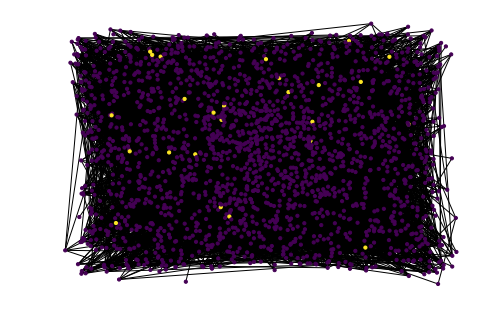

In [8]:
# Найдём k наибольших собственных векторов
k = 2 # k можно подставлять каким угодно
num_nodes = (D.shape[0])

X_sym = v_sym[:, num_nodes - k:]

# Создадим матрицу Y - нормализованных значений X
Y_sym = np.divide(X_sym, np.reshape(np.linalg.norm(X_sym, axis=1), (X_sym.shape[0], 1)))

# Кластеризуем используя алгоритм k-means 
kmeans = KMeans(n_clusters=k).fit(Y_sym)

# Пометим точки на графе
cluster_labels = kmeans.labels_
nx.draw(G, node_size=10, pos=nx.spring_layout(G, k=0.05, iterations=1), node_color=cluster_labels)

In [9]:
#Выведем исполнителей
batch_size = 10
for i in range(k):
    print("")
    print("")
    print("cluster number ", i)
    print("")
    j = 0
    for label_num in range(len(cluster_labels)):
        if cluster_labels[label_num] == i:
            print(artists[label_num])
            j += 1
            if j == batch_size:
                break
        



cluster number  0

Wu-Syndicate 
Oregon 
Angela Bofill
Drain S.T.H. 
Guided By Voices 
Sarah Sadler 
Sneaker Pimps
The Mars Volta 
Erik Friedlander 
Tujiko Noriko


cluster number  1

Masque 
Dawkins & Dawkins
Karen Clark Sheard 
Dr. Charles G. Hayes & The Cosmopolitan Warriors 
Gary Oliver
BeBe & CeCe Winans 
Woody Rock 
Donald Lawrence
Richard Smallwood
Mary Mary
